In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel, DistilBertTokenizer
import numpy as np
import os
import re

# Define data directories
data_dir = r"/work/TALC/enel645_2025w/garbage_data/"
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

### IMAGE ###
# Define transformations
transform = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
                                                                           
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}
### MODEL ###
class CombinedClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(CombinedClassifier, self).__init__()
        ## Image
        self.mobile_net = models.mobilenet_v2(pretrained=True)

        for param in self.mobile_net.features.parameters():
            param.requires_grad = False

        in_features_img = self.mobile_net.classifier[1].in_features
        self.mobile_net.classifier = nn.Identity()
        
        ## Text
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        hidden_size_text = self.distilbert.config.hidden_size

        # Normalization Layer
        self.image_norm = nn.LayerNorm(in_features_img)
        self.text_norm = nn.LayerNorm(hidden_size_text)

        ## FC Layers
        self.fc1 = nn.Linear(in_features_img + hidden_size_text, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)


    def forward(self, image, input_ids, attention_mask):
        # Image
        image_features = self.mobile_net(image)
        image_features = self.image_norm(image_features)

        # Text
        text_features = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
        text_features = text_features[:, 0]
        text_features = self.text_norm(text_features)
        
        # Concatenate image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)

        output = F.relu(self.fc1(combined_features))
        output = self.dropout(output)
        output = F.relu(self.fc2(output))
        output = self.dropout(output)
        output = self.fc3(output)

        return output

# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    image_paths = []
    class_folders = sorted(os.listdir(path))  
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text)
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])
                    image_paths.append(file_path)

    return np.array(texts), np.array(labels), np.array(image_paths)

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, texts, labels, tokenizer, max_len, transform):
        self.image_paths = image_paths
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = datasets.folder.default_loader(self.image_paths[idx])
        image = self.transform(image)

        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load and process datasets
text_train, labels_train, image_paths_train = read_text_files_with_labels(train_dir)
text_val, labels_val, image_paths_val = read_text_files_with_labels(val_dir)
text_test, labels_test, image_paths_test = read_text_files_with_labels(test_dir)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define dataset
max_len = 24
dataset_train = CustomDataset(image_paths_train, text_train, labels_train, tokenizer, max_len, transform["train"])
dataset_val = CustomDataset(image_paths_val, text_val, labels_val, tokenizer, max_len, transform["val"])
dataset_test = CustomDataset(image_paths_test, text_test, labels_test, tokenizer, max_len, transform["test"])

# Data loaders
train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=8, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=8, shuffle=False)

dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}

# Training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in dataloader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        output = model(images, input_ids, attention_mask)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, preds = torch.max(output, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            output = model(images, input_ids, attention_mask)
            loss = criterion(output, labels)

            total_loss += loss.item()

            # Calculate accuracy
            _, preds = torch.max(output, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

def predict(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():  # Disable gradient tracking
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)

            # Get predictions
            _, preds = torch.max(outputs, dim=1)

            # Convert predictions to CPU and append to the list
            predictions.extend(preds.cpu().numpy())

    return predictions

# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CombinedClassifier().to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

best_loss = 1e+10
EPOCHS = 5

# Training loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, dataloaders["train"], optimizer, criterion, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}', flush=True)
    
    val_loss, val_acc = evaluate(model, dataloaders["val"], criterion, device)
    print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}', flush=True)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model1.pth')

print("Training complete.")


model.load_state_dict(torch.load('best_model.pth'))
# Evaluation
test_predictions = predict(model, dataloaders["test"], device)
print(f"Accuracy:  {(test_predictions == labels_test).sum()/labels_test.size:.4f}")

Epoch 1, Train Loss: 0.5489, Train Acc: 0.8123
Epoch 1, Val Loss: 0.3341, Val Acc: 0.8839
Epoch 2, Train Loss: 0.2960, Train Acc: 0.9032
Epoch 2, Val Loss: 0.3097, Val Acc: 0.8983
Epoch 3, Train Loss: 0.2273, Train Acc: 0.9271
Epoch 3, Val Loss: 0.3141, Val Acc: 0.8911
Epoch 4, Val Loss: 0.3299, Val Acc: 0.8978
Epoch 5, Train Loss: 0.1650, Train Acc: 0.9463
Epoch 5, Val Loss: 0.3348, Val Acc: 0.9061
Training complete.
Accuracy:  0.8590


In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


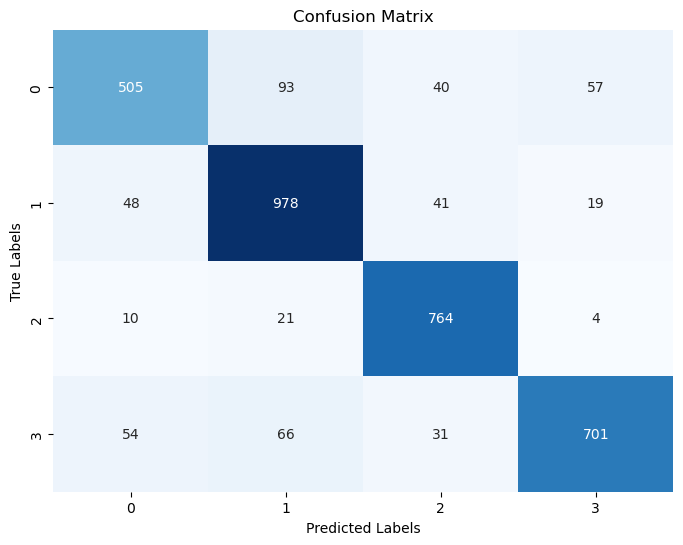

In [ ]:
cm = confusion_matrix(labels_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()